<a href="https://colab.research.google.com/github/JeehwanLim/202103-adv_ml/blob/main/Adv_ML_Fin_Prj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 기말 텀 프로젝트 3조
> Diamond 가격 예측

## 1. 라이브러리 Import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 2. 데이터 가져오기

In [ ]:
!git clone https://github.com/JeehwanLim/202103-adv_ml.git

fatal: destination path '202103-adv_ml' already exists and is not an empty directory.


In [ ]:
df = pd.read_csv('202103-adv_ml/diamonds.csv', sep=',')
df.shape

(53940, 11)

## 3. 탐색적 자료 분석

In [ ]:
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [ ]:
df.describe()

,Unnamed: 0,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,26970.500000,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,15571.281097,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,1.000000,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,13485.750000,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,26970.500000,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,40455.250000,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,53940.000000,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [ ]:
idx_list = df[(df["x"]==0) | (df["y"]==0) | (df["z"]==0)].index
data = df.drop(idx_list)
print(data.shape)

(53920, 11)


* x,y,z 칼럼에 0 값이 존재하는 레코드들은 제거함

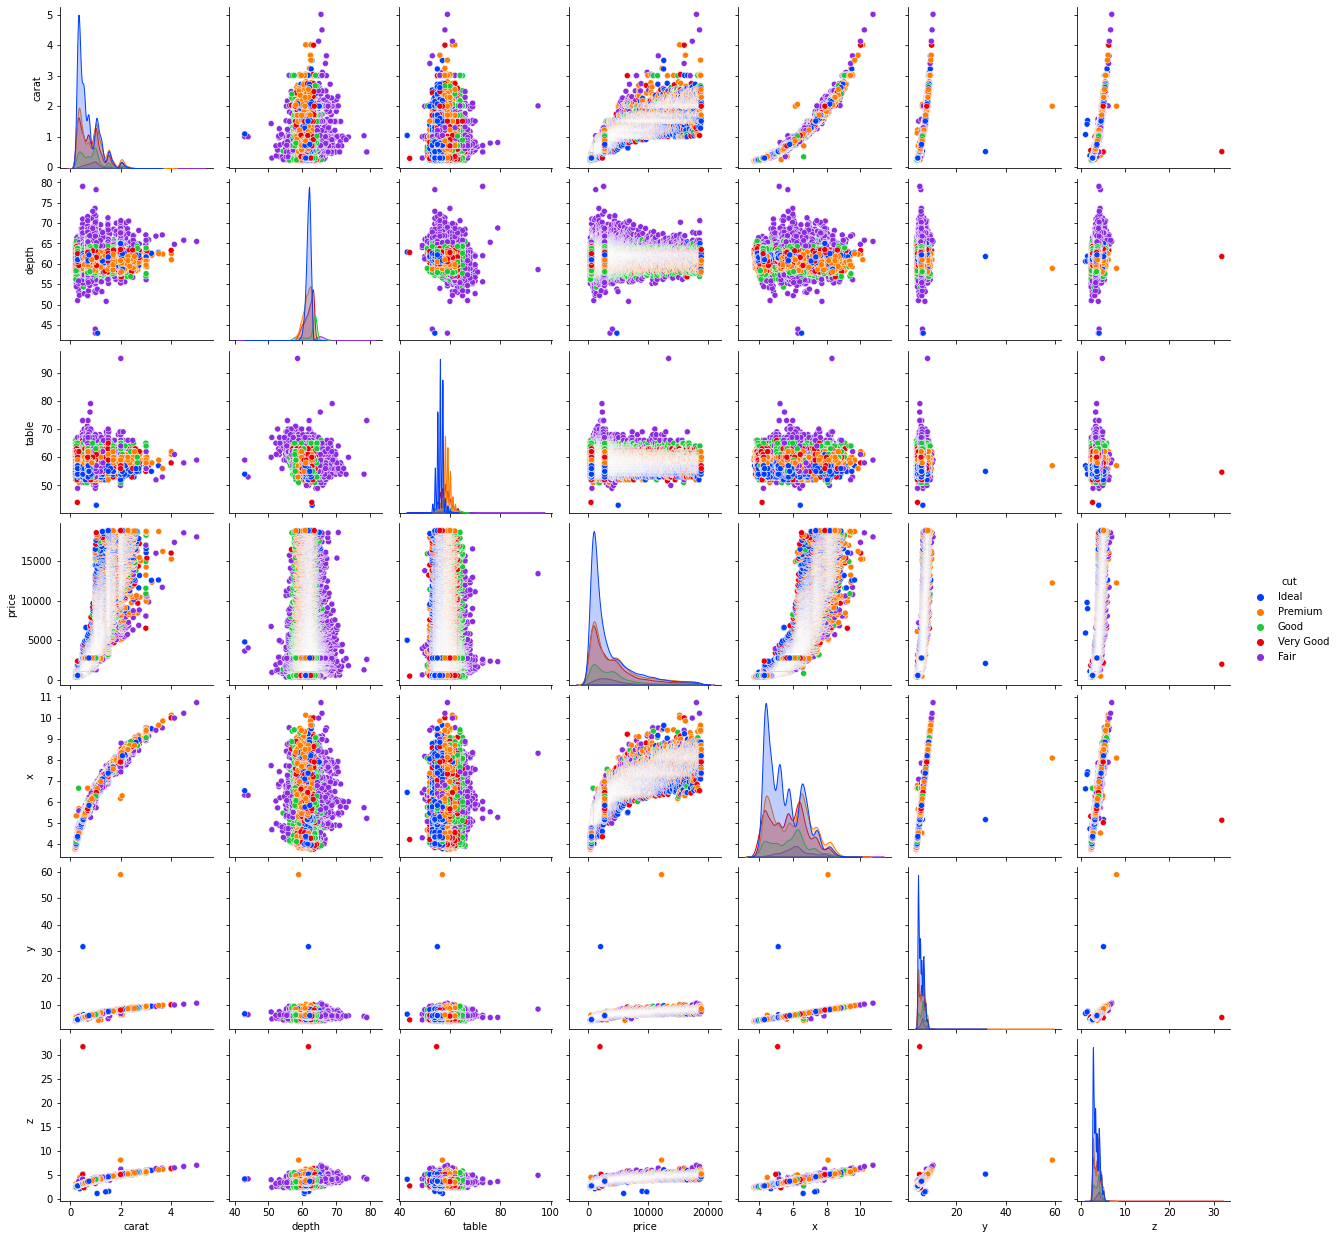

In [ ]:
# 이 셀은 실행하지 말것. 시간 오래 걸림 
# sns.pairplot(data.iloc[:,1:], 
#             diag_kind='kde',
#             hue="cut", 
#             palette='bright') # pastel, bright, deep, muted, colorblind, dark
# plt.show()

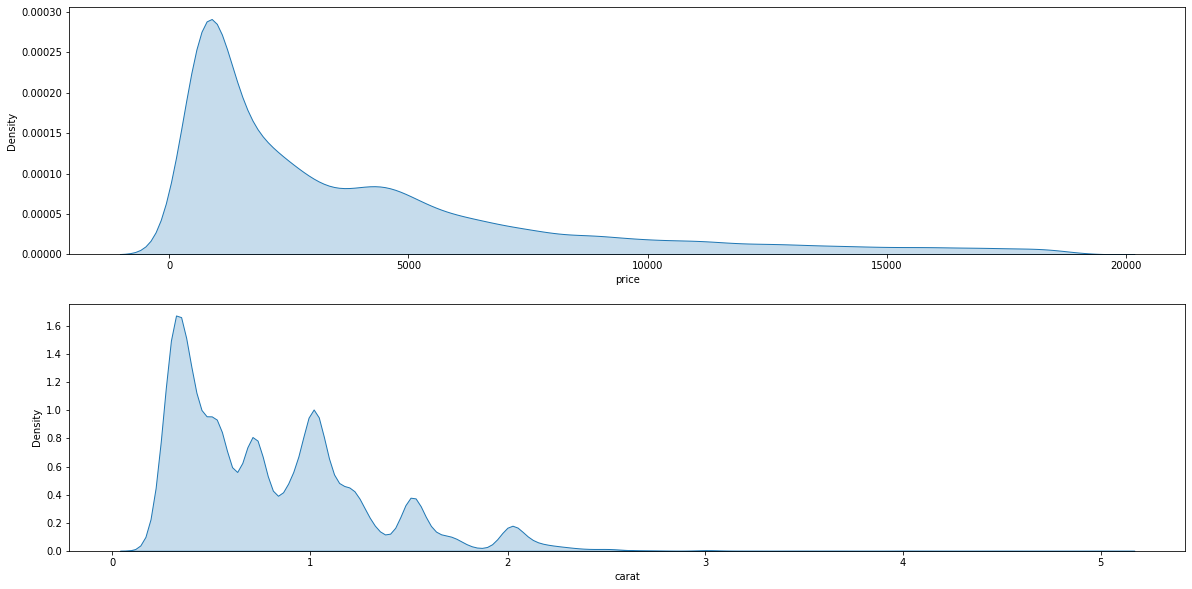

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(2,1,1)
sns.kdeplot(data.price, shade=True)

plt.subplot(2,1,2)
sns.kdeplot(data.carat, shade=True)

plt.show()

* scatterplot matrix의 가격 행을 보면 Depth, table, y, z 특성에서 outlier가 발견된다. 
* Carat 의 분포를 살펴보면 특정 값(0.3, 0.5, 0.7, 1.0, 1.5, 2.0) 에서 density가 높은 것을 알 수 있다.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


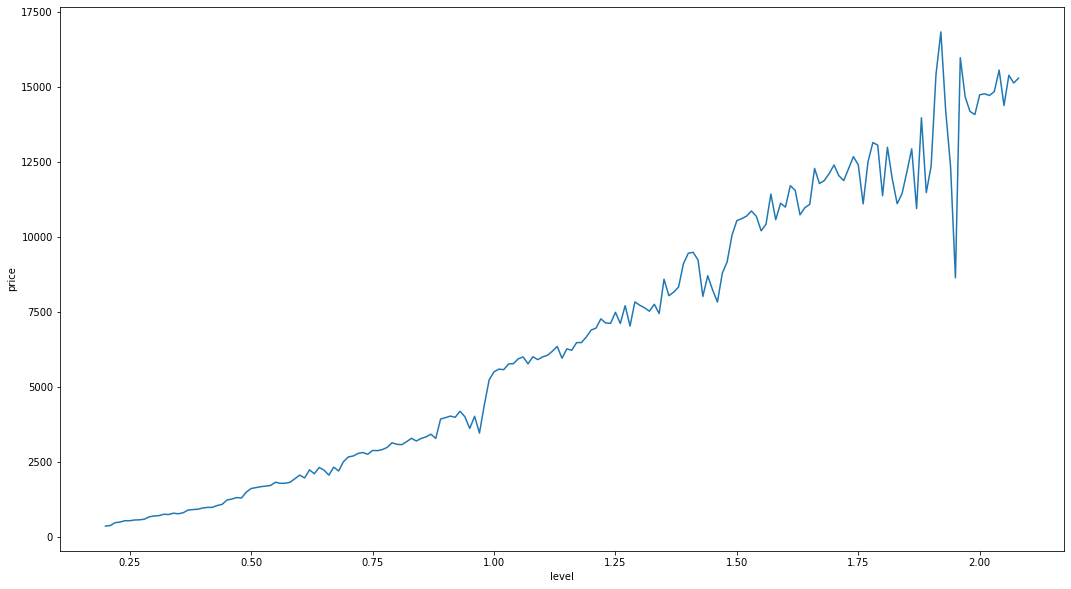

In [ ]:
data2 = data[['price','carat']]

bins = list(np.arange(0.2, 2.1, 0.01))
bins_label = [x for x in bins]
data2["level"] = pd.cut(df["carat"], bins, right=False, labels=bins_label[:-1])
grouped = data2.groupby(['level'], as_index=False).mean()

plt.figure(figsize=(18,10))
sns.lineplot('level', 'price', data=grouped)

* carat과 가격만 놓고 보면 주변보다 캐럿의 density가 높은 곳에서 가격이 급격하게 높아지는 경향을 보인다.